In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import pymc3 as pm
import seaborn as sns
import matplotlib.pyplot as plt
import pdb
sns.set_style("ticks")

rseed = 20090425
np.random.seed(rseed)

In [2]:
sns.set_style("ticks")

Import relevant data from KQ4 spreadsheet.

In [3]:
keep_columns = ['Author', 'Year', 'Refid', 'Pre-op', 'Initial Surgery', 'Morcellation',
       'Power', 'Upstaged', 'Months follow-up',
       'Median_\nFUP_time', 'Range_\nFUP_Time', 'Outcome', 'Age',
       'Menopausal Status', 'Lost_to_Fup', 'Include', 'Inclusion staging criteria restricted or not (y/n)']

kq4_data = (pd.read_excel('data/UF_KQ4_data_for_Chris_12142016_SK.xlsx', sheetname='All_KQ4_data_Original', 
                         na_values=['NR', 'NA'])[keep_columns]
                .rename(columns={'Months follow-up': 'fup_months',
                               'Median_\nFUP_time': 'fup_median', 
                               'Range_\nFUP_Time': 'fup_range',
                                'Pre-op': 'preop', 
                                 'Initial Surgery': 'surgery_init',
                                'Menopausal Status': 'menop_status',
                                'Inclusion staging criteria restricted or not (y/n)': 'stage_include'}))

kq4_data.columns = kq4_data.columns.str.lower()

Drop excludes (rows colored yellow in the spreadsheet, or those with "lost_to_fup" values instead of censoring time).

In [4]:
kq4_data = kq4_data[(kq4_data.include==1) & (kq4_data.lost_to_fup!='yes')].drop(['include', 'lost_to_fup'], axis=1)

In [5]:
kq4_data.head()

,author,year,refid,preop,surgery_init,morcellation,power,upstaged,fup_months,fup_median,fup_range,outcome,age,menop_status,stage_include
0,Einstein,2008.0,405,Benign,LSC SCH,Yes,Yes,No,30.0,NaN,NaN,NED,NaN,NaN,No
1,Einstein,2008.0,405,Benign,LMYOM,Yes,Yes,Yes,61.0,NaN,NaN,NED,NaN,NaN,No
2,Einstein,2008.0,405,Benign,SCH,Yes,No,Yes,31.0,NaN,NaN,AWD,NaN,NaN,No
3,Einstein,2008.0,405,Benign,SCH BSO,No,No,No,37.0,NaN,NaN,NED,NaN,NaN,No
4,Einstein,2008.0,405,Benign,SCH BSO,No,No,Yes,6.0,NaN,NaN,AWD,NaN,NaN,No


Distribution of age (if not missing)

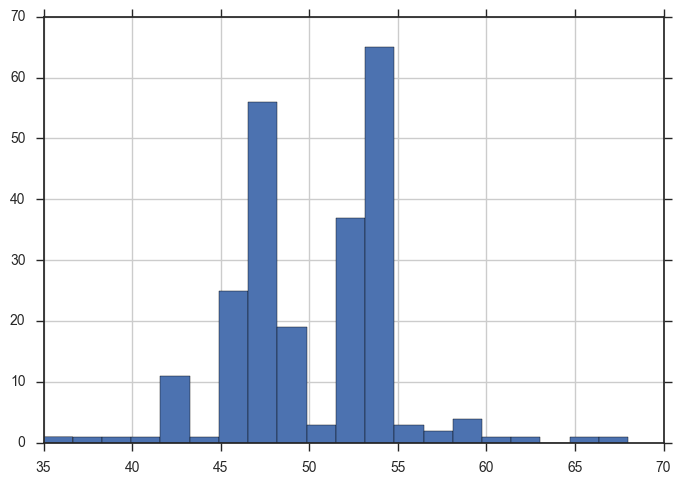

In [6]:
kq4_data.age.hist(bins=20)

Note that half the ages are missing:

In [7]:
kq4_data.isnull().mean().round(2)

author           0.00
year             0.00
refid            0.00
preop            0.08
surgery_init     0.00
morcellation     0.00
power            0.09
upstaged         0.69
fup_months       0.00
fup_median       0.35
fup_range        0.34
outcome          0.00
age              0.48
menop_status     0.76
stage_include    0.02
dtype: float64

In [8]:
kq4_data.groupby('refid').year.max().value_counts()

2015.0    10
2016.0     7
2008.0     2
2014.0     2
2010.0     1
2013.0     1
1999.0     1
2009.0     1
2011.0     1
2012.0     1
Name: year, dtype: int64

In [9]:
stage1_only = True
    
if stage1_only:
    kq4_data = kq4_data[kq4_data.stage_include=='Yes']

Drop those with missing `power` or `morcellation` covariates. Perhaps we can impute later.

In [10]:
kq4_data = kq4_data.dropna(subset=['morcellation', 'power']).reset_index(drop=True)

Values are a mess in several columns:

In [11]:
kq4_data.outcome.value_counts()

Alive    124
alive     52
dead      46
Dead      27
AWD       16
Died      14
Name: outcome, dtype: int64

In [12]:
kq4_data['preop'].value_counts()

benign     193
Benign      46
sarcoma      3
Name: preop, dtype: int64

In [13]:
kq4_data.outcome = kq4_data.outcome.replace({'Alive': 'alive',
                         'Dead': 'dead',
                         'AWD': 'awd',
                         'NED': 'ned',
                         'Died': 'dead'})
kq4_data.outcome.value_counts()

alive    176
dead      87
awd       16
Name: outcome, dtype: int64

In [14]:
kq4_data.preop = kq4_data.preop.str.strip().replace({'Benign': 'benign'})
kq4_data['preop'].value_counts()

benign     239
sarcoma      3
Name: preop, dtype: int64

This is also a mess. Need to fix.

In [15]:
pd.crosstab(kq4_data.morcellation, kq4_data.power)

power,No,Yes,no,yes
morcellation,,,,
No,199,0,0,0
Yes,14,8,24,0
yes,13,0,0,21


In [16]:
kq4_data.morcellation = kq4_data.morcellation.str.lower()
kq4_data.power = kq4_data.power.str.lower()

pd.crosstab(kq4_data.morcellation, kq4_data.power)

power,no,yes
morcellation,,
no,199,0
yes,51,29


Create death outcome column

In [17]:
kq4_data['died'] = (kq4_data.outcome=='dead').astype(int)
kq4_data.died.value_counts()

0    192
1     87
Name: died, dtype: int64

In [18]:
kq4_data.head(20)

,author,year,refid,preop,surgery_init,morcellation,power,upstaged,fup_months,fup_median,fup_range,outcome,age,menop_status,stage_include,died
0,Lin,2015.0,826,benign,TAH,no,no,No,34.0,yes,1-248,alive,52.7,NaN,Yes,0
1,Lin,2015.0,826,benign,TAH,no,no,NaN,34.0,yes,1-248,alive,52.7,NaN,Yes,0
2,Lin,2015.0,826,benign,TAH,no,no,NaN,34.0,yes,1-248,alive,52.7,NaN,Yes,0
3,Lin,2015.0,826,benign,TAH,no,no,NaN,34.0,yes,1-248,alive,52.7,NaN,Yes,0
4,Lin,2015.0,826,benign,TAH,no,no,NaN,34.0,yes,1-248,alive,52.7,NaN,Yes,0
5,Lin,2015.0,826,benign,TAH,no,no,NaN,34.0,yes,1-248,alive,52.7,NaN,Yes,0
6,Lin,2015.0,826,benign,TAH,no,no,NaN,34.0,yes,1-248,alive,52.7,NaN,Yes,0
7,Lin,2015.0,826,benign,TAH,no,no,NaN,34.0,yes,1-248,alive,52.7,NaN,Yes,0
8,Lin,2015.0,826,benign,TAH,no,no,NaN,34.0,yes,1-248,alive,52.7,NaN,Yes,0
9,Lin,2015.0,826,benign,TAH,no,no,NaN,34.0,yes,1-248,alive,52.7,NaN,Yes,0


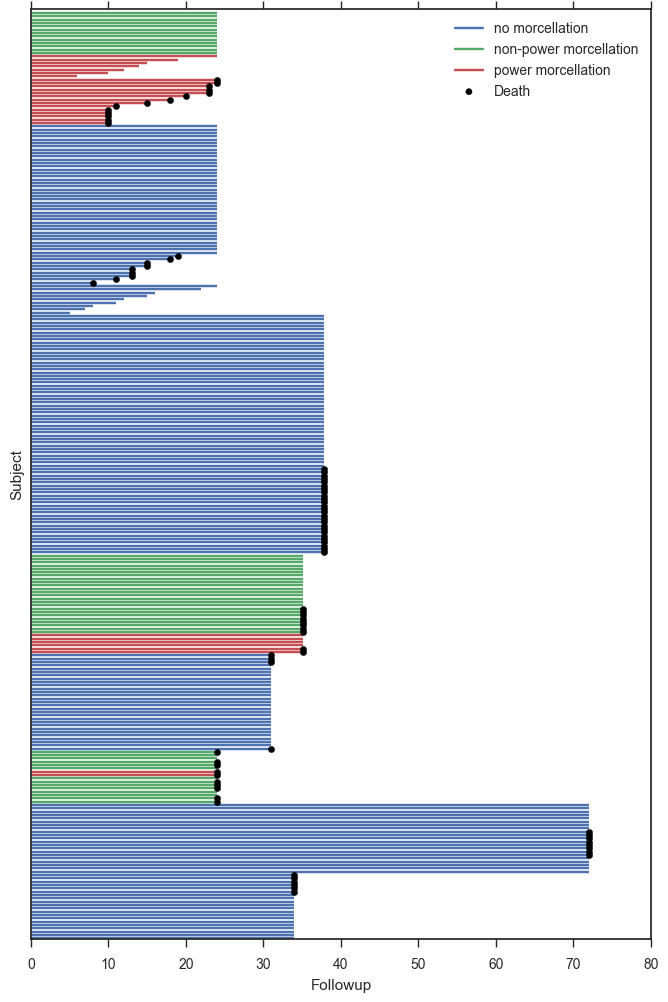

In [19]:
fig, ax = plt.subplots(figsize=(8, 12))
n_patients = kq4_data.shape[0]

time = kq4_data.fup_months

ix0 = kq4_data.morcellation=='no'
ix1 = (kq4_data.morcellation=='yes') & (kq4_data.power=='no')
ix2 = (kq4_data.morcellation=='yes') & (kq4_data.power=='yes')

blue, green, red = sns.color_palette()[:3]

ax.hlines(kq4_data.index[ix0], 0, time[ix0],
          color=blue, label='no morcellation')

ax.hlines(kq4_data.index[ix1], 0, time[ix1],
          color=green, label='non-power morcellation')

ax.hlines(kq4_data.index[ix2], 0, time[ix2],
          color=red, label='power morcellation')

ax.scatter(time[kq4_data.died == 1], kq4_data.index[kq4_data.died == 1],
           color='k', zorder=10, label='Death');

ax.set_xlim(left=0)
ax.set_ylabel('Subject')
ax.set_xlabel('Followup')
ax.set_yticks([])

ax.set_ylim(-0.25, n_patients + 0.25)

ax.legend(loc='upper right');

In [20]:
from lifelines import KaplanMeierFitter
kmf = KaplanMeierFitter()

In [21]:
kmf.fit(kq4_data.fup_months, event_observed=kq4_data.died)

<lifelines.KaplanMeierFitter: fitted with 279 observations, 192 censored>

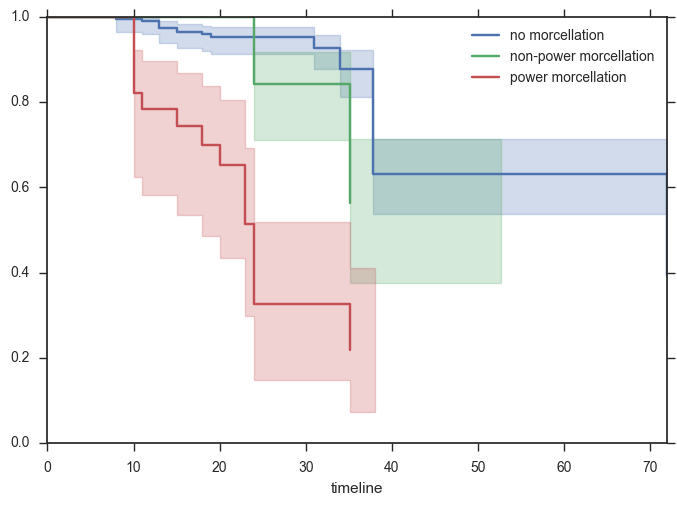

In [22]:
time = kq4_data.fup_months
event = event_observed=kq4_data.died
ix0 = kq4_data.morcellation=='no'
ix1 = (kq4_data.morcellation=='yes') & (kq4_data.power=='no')
ix2 = (kq4_data.morcellation=='yes') & (kq4_data.power=='yes')



kmf.fit(time[ix0], event[ix0], label='no morcellation')
ax = kmf.plot()

kmf.fit(time[ix1], event[ix1], label='non-power morcellation')
kmf.plot(ax=ax)

kmf.fit(time[ix2], event[ix2], label='power morcellation')
kmf.plot(ax=ax)

Some studies show event time truncated to the end of the followup period. These values should be treated as **missing** and their values imputed from the range of possible followup times.

In [23]:
kq4_data.loc[kq4_data.fup_median.notnull(), 'fup_months'] = np.nan

In [24]:
kq4_data['fup_min'] = 0
kq4_data['fup_max'] = kq4_data.fup_months.max()

fup_min, fup_max = np.transpose([[float(x[0]), float(x[1])] for x in kq4_data.fup_range[kq4_data.fup_median.notnull()].str.split('-')])

If the event was a death event, make the `fup_min` equal to zero.

In [25]:
kq4_data.loc[kq4_data.fup_median.notnull(), 'fup_min'] = fup_min * ((1-kq4_data.died)[kq4_data.fup_median.notnull()])
kq4_data.loc[kq4_data.fup_median.notnull(), 'fup_max'] = fup_max

Summarize proportion of missing values

In [26]:
kq4_data.isnull().mean().round(2)

author           0.00
year             0.00
refid            0.00
preop            0.13
surgery_init     0.00
morcellation     0.00
power            0.00
upstaged         0.67
fup_months       0.67
fup_median       0.33
fup_range        0.33
outcome          0.00
age              0.69
menop_status     0.76
stage_include    0.00
died             0.00
fup_min          0.00
fup_max          0.00
dtype: float64

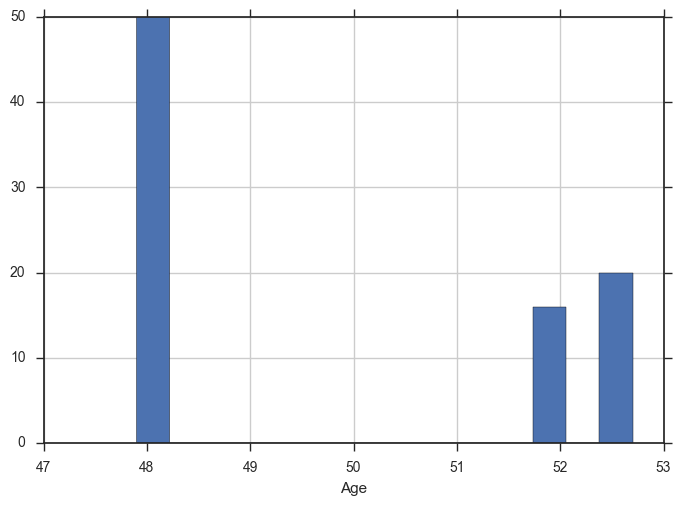

In [27]:
axes = kq4_data.age.hist(bins=15)
axes.set_xlabel('Age')

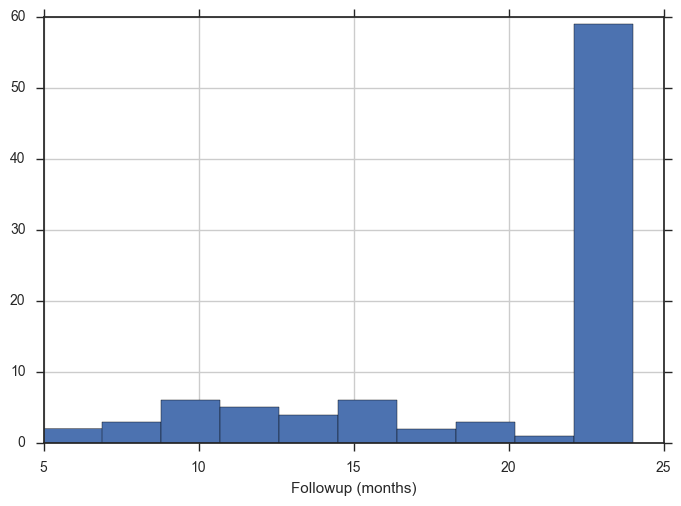

In [28]:
axes = kq4_data['fup_months'].hist()
axes.set_xlabel('Followup (months)')

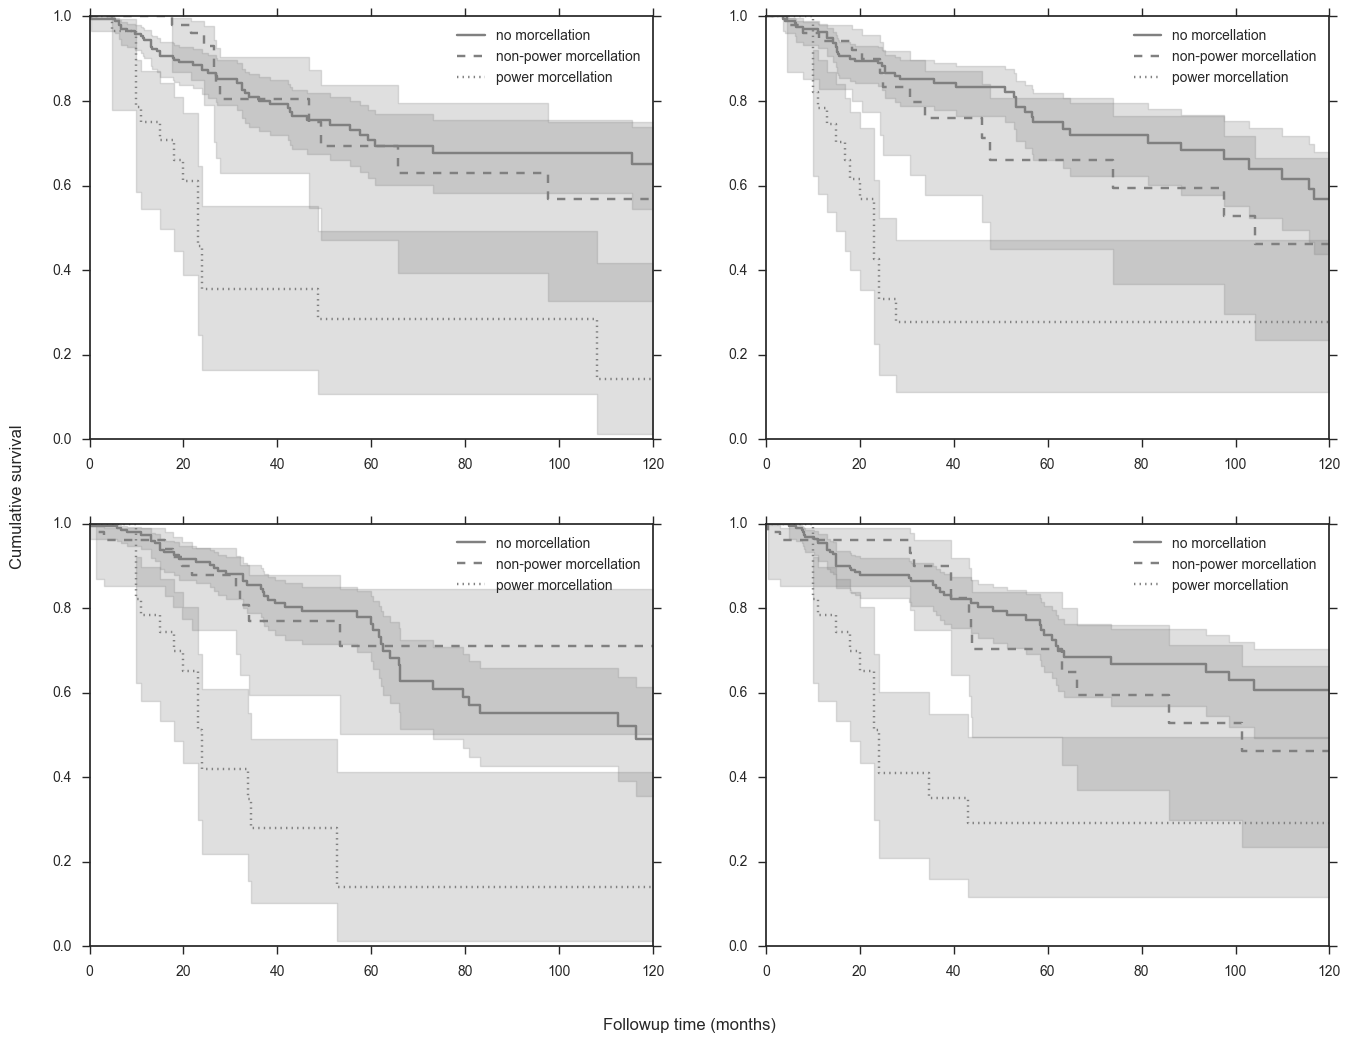

In [29]:
fig, axes = plt.subplots(2,2,figsize=(16,12))

for ax in axes.flatten():
    
    time_sim = kq4_data.fup_months.copy()
    event = event_observed=kq4_data.died
    missing_times = kq4_data.fup_months.isnull()
    time_sim.loc[missing_times] = np.random.uniform(kq4_data.fup_min[missing_times] * ((1-kq4_data.died)[missing_times]),
                                                    kq4_data.fup_max[missing_times])
    
    ix0 = kq4_data.morcellation=='no'
    ix1 = (kq4_data.morcellation=='yes') & (kq4_data.power=='no')
    ix2 = (kq4_data.morcellation=='yes') & (kq4_data.power=='yes')

    kmf = KaplanMeierFitter()
    kmf.fit(time_sim[ix0], event[ix0], label='no morcellation')
    kmf.plot(ax=ax, color='grey')

    kmf.fit(time_sim[ix1], event[ix1], label='non-power morcellation')
    kmf.plot(ax=ax, ls='dashed', color='grey')

    kmf.fit(time_sim[ix2], event[ix2], label='power morcellation')
    kmf.plot(ax=ax, ls='dotted', color='grey')
    
    ax.set_xlim(0, 120)
    ax.set_xlabel('')

fig.text(0.5, 0.06, 'Followup time (months)', ha='center', va='center')
fig.text(0.08, 0.5, 'Cumulative survival', ha='center', va='center', rotation='vertical')

In [30]:
model_data = (kq4_data.assign(non_power_morcellation=(kq4_data.morcellation=='yes') & (kq4_data.power=='no'))
                      .assign(power_morcellation=(kq4_data.morcellation=='yes') & (kq4_data.power=='yes')))

In [31]:
time = model_data['fup_months']
event = event_observed = model_data.died.astype(int)
n_intervals = int(time.max()+1)
n_patients = model_data.shape[0]
refid = model_data.refid.values

In [32]:
time_missing = model_data['fup_months'].copy()
time_missing[time_missing.isnull()] = 1
time_masked = np.ma.masked_values(time_missing, value=1)

#non_power, power = model_data[['non_power_morcellation', 'power_morcellation']].values.astype(int).T
power = (model_data.power=='yes').astype(int)
morcellation = (model_data.morcellation=='yes').astype(int)

In [33]:
fup_min, fup_max = model_data[['fup_min', 'fup_max']].T.values

The study IDs used in the analyis:

In [34]:
studies = model_data.refid.unique()
studies

array([826, 364, 286, 932, 2114], dtype=object)

In [35]:
study_ind = np.array([np.where(studies==id)[0][0] for id in refid])

In [36]:
from pymc3 import Normal, Deterministic, sample, HalfCauchy, Model, DensityDist, Metropolis, Potential, Exponential, Uniform
from pymc3 import traceplot, forestplot, summary, sample_ppc
import theano.tensor as tt

In [37]:
with Model() as exp_model:

    # Study random effect
    μ = Normal('μ', 0, sd=100)
    σ = pm.Uniform('σ', 0, 100)
    ζ = pm.Normal('ζ', 0, 1, shape=len(studies))
    θ = (μ + ζ*σ)[study_ind]

    # Effects of morcellation and power
    β = Normal('β', mu=0.0, sd=100, shape=2)

    # Survival rates
    λ = Deterministic('λ', tt.exp(θ + β[0] * morcellation + β[1] * power))
    
    # Impute missing event times
#     time_imputed = Exponential('time_imputed', lam=λ, observed=time_masked)
    time_imputed = Uniform('time_imputed', lower=fup_min, upper=fup_max, observed=time_masked)
    
    # Impose bound on missing times
    fup_bound = Potential('fup_bound', Uniform.dist(lower=fup_min, upper=fup_max).logp(time_imputed))

    # Exponential survival likelihood, accounting for censoring
    def logp(event):
        return event * tt.log(λ) - λ * time_imputed

    survival = DensityDist('survival', logp, observed={'event':event})


In [38]:
n_iterations = 200000
n_burn = 100000

In [39]:
with exp_model:
    start = {'time_imputed_missing': np.random.uniform((model_data.fup_min)[model_data.fup_months.isnull()],
                                                      (model_data.fup_max)[model_data.fup_months.isnull()])}
    exp_trace = sample(n_iterations, step=Metropolis(), start=start, random_seed=rseed)

100%|██████████| 200000/200000 [01:55<00:00, 1737.35it/s]


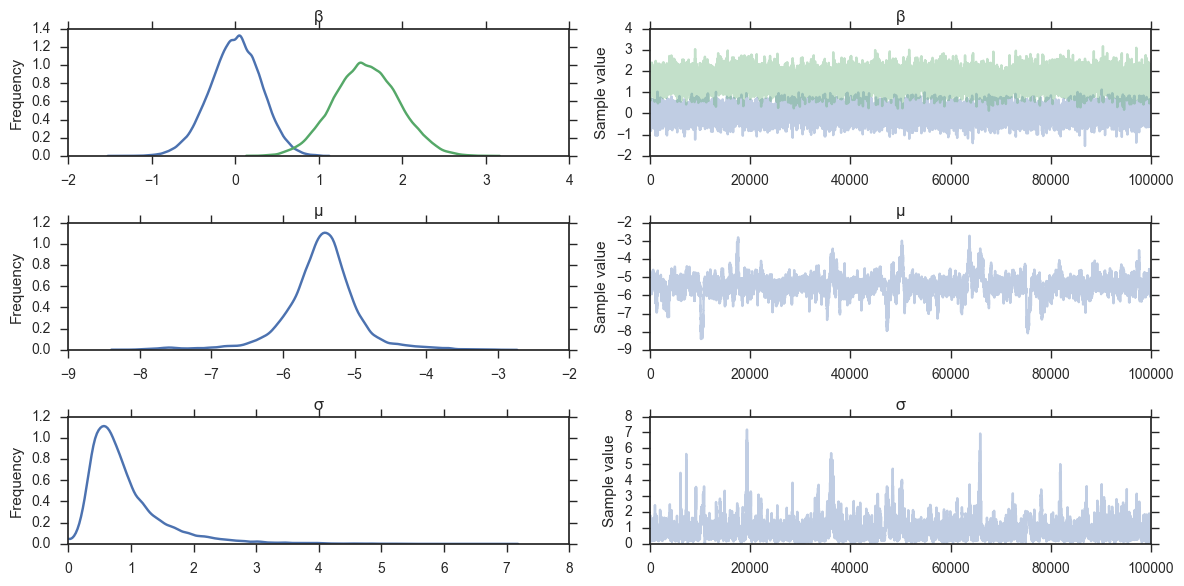

In [40]:
traceplot(exp_trace[n_burn:], varnames=['β', 'μ', 'σ']);

In [41]:
summary(exp_trace[n_burn:], varnames=['β'])


β:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  -0.005           0.306            0.005            [-0.620, 0.583]
  1.568            0.389            0.009            [0.830, 2.350]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  -0.626         -0.205         0.002          0.204          0.578
  0.813          1.304          1.564          1.832          2.336



Imputed follow-up times

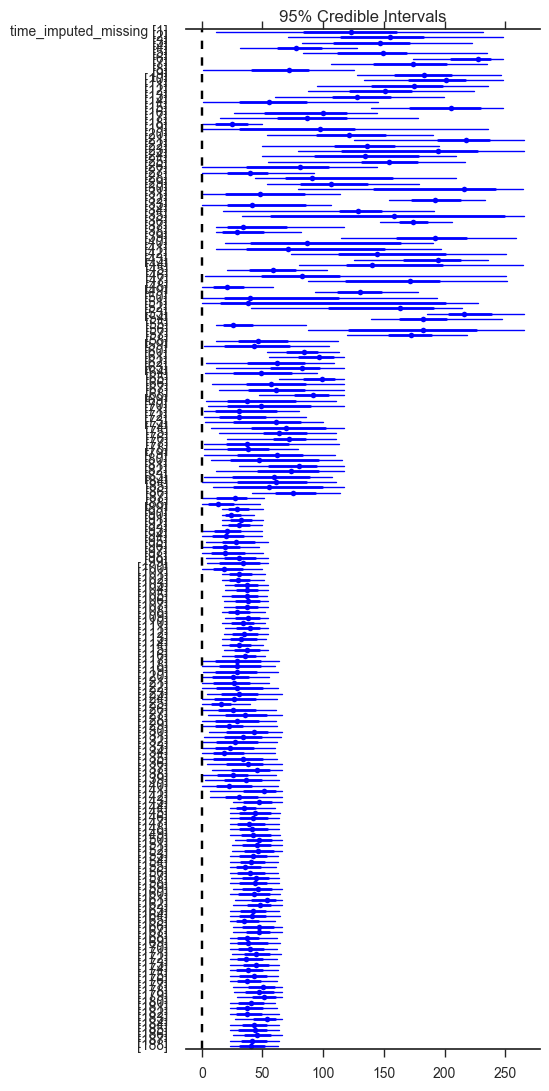

In [42]:
plt.figure(figsize=(6,12))
forestplot(exp_trace, varnames=['time_imputed_missing'])

In [43]:
# baseline_hazard = np.exp(exp_trace['β'][n_burn:, 0])
# non_power_hazard = np.exp(exp_trace['β'][n_burn:, 0] + exp_trace['β'][n_burn:, 1])
# power_hazard = np.exp(exp_trace['β'][n_burn:, 0] + exp_trace['β'][n_burn:, 1] + exp_trace['β'][n_burn:, 2])

In [44]:
baseline_hazard = np.exp(exp_trace['μ'][n_burn:])
non_power_hazard = np.exp(exp_trace['μ'][n_burn:] + exp_trace['β'][n_burn:, 0])
power_hazard = np.exp(exp_trace['μ'][n_burn:] + exp_trace['β'][n_burn:, 0] + exp_trace['β'][n_burn:, 1])

Since this is a constant-hazard model, we can easily summarize the hazard estimates.

In [45]:
hazard_df = pd.DataFrame({'baseline':baseline_hazard, 'non-power':non_power_hazard, 'power':power_hazard})
hazard_df.describe(percentiles=[0.025, 0.975]).T[['mean', '2.5%', '97.5%']].round(4)

,mean,2.5%,97.5%
baseline,0.0049,0.0012,0.0127
non-power,0.0050,0.0010,0.0133
power,0.0240,0.0052,0.0603


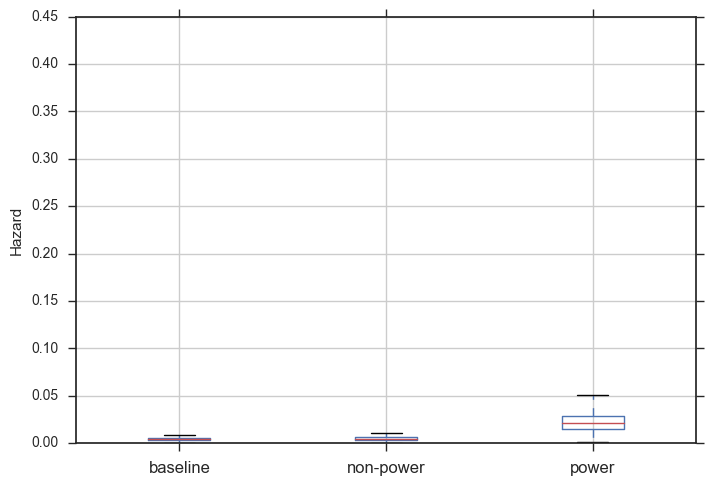

In [46]:
hazard_df.boxplot()
plt.ylabel('Hazard');

In [47]:
def cum_hazard(hazard, n=n_intervals):
    return (np.arange(n) * hazard.reshape(-1,1)).cumsum(axis=-1)

def survival(hazard):
    return np.exp(-cum_hazard(hazard))

In [48]:
def plot_with_hpd(x, hazard, f, ax, color=None, label=None, alpha=0.05, **kwargs):

    mean = f(hazard.mean(axis=0), **kwargs)
    
    percentiles = 100 * np.array([alpha / 2., 1. - alpha / 2.])
    hpd = np.percentile(f(hazard, **kwargs), percentiles, axis=0)
    
    ax.fill_between(x, hpd[0], hpd[1], color=color, alpha=0.25)
    ax.step(x, mean.squeeze(), color=color, label=label);

In [49]:
interval_bounds = np.arange(0, time.max() + 2, 1)

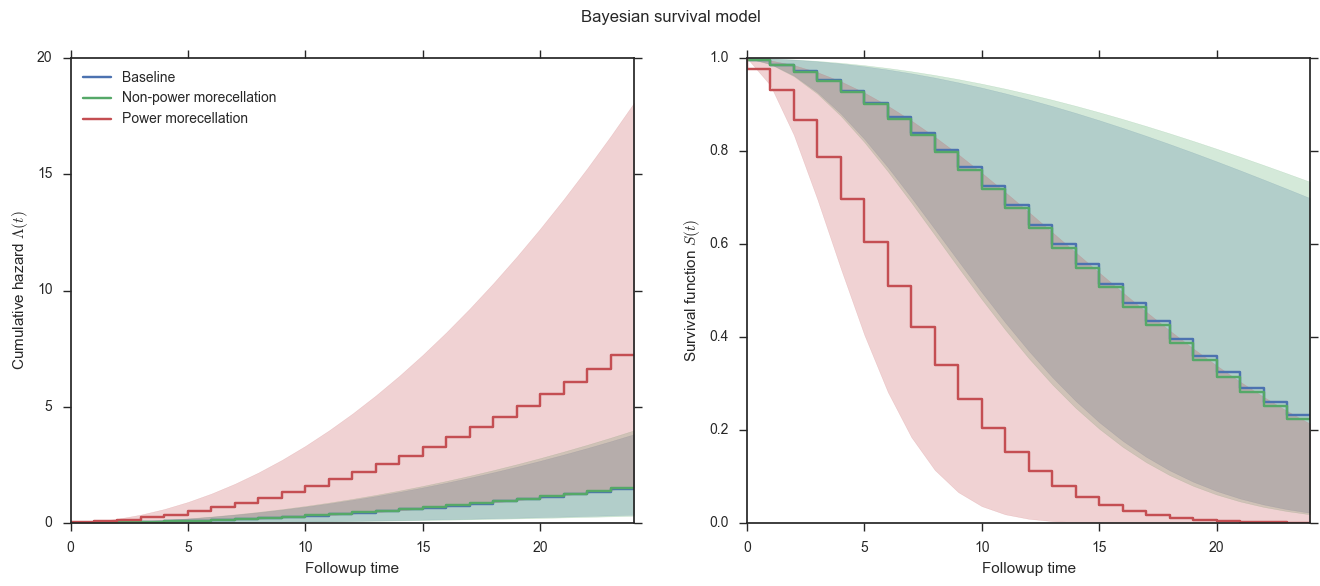

In [50]:
fig, (hazard_ax, surv_ax) = plt.subplots(ncols=2, sharex=True, sharey=False, figsize=(16, 6))

plot_with_hpd(interval_bounds[:-1], baseline_hazard, cum_hazard,
              hazard_ax, color=blue, label='Baseline')
plot_with_hpd(interval_bounds[:-1], non_power_hazard, cum_hazard,
              hazard_ax, color=green, label='Non-power morecellation')
plot_with_hpd(interval_bounds[:-1], power_hazard, cum_hazard,
              hazard_ax, color=red, label='Power morecellation')

hazard_ax.set_xlim(0, time.max());
hazard_ax.set_xlabel('Followup time');

hazard_ax.set_ylabel(r'Cumulative hazard $\Lambda(t)$');

hazard_ax.legend(loc=2);

plot_with_hpd(interval_bounds[:-1], baseline_hazard, survival,
              surv_ax, color=blue)
plot_with_hpd(interval_bounds[:-1], non_power_hazard, survival,
              surv_ax, color=green)
plot_with_hpd(interval_bounds[:-1], power_hazard, survival,
              surv_ax, color=red)

surv_ax.set_xlim(0, time.max());
surv_ax.set_xlabel('Followup time');

surv_ax.set_ylabel('Survival function $S(t)$');

fig.suptitle('Bayesian survival model');

Unfortunately, the exponential (*i.e.* constant hazard) model does not seem to fit the data, based on the comparison between the K-M curves and the survival function. 

Below, we try a Weibull model for the survival function.

## Weibull survival model

In [51]:
from pymc3 import Weibull, df_summary

In [52]:
with Model() as weibull_model:

    # Study random effect
    μ = Normal('μ', 0, sd=10)
    σ = pm.HalfCauchy('σ', 2.5)
    ζ = pm.Normal('ζ', 0, 1, shape=len(studies))
    θ = (μ + ζ*σ)[study_ind]

    # Weibull shape parameter
    k = pm.HalfCauchy('k', 2.5)
    # Effects of morcellation and power
    β = Normal('β', mu=0.0, sd=10, shape=2)

    # Weibull scales
    λ = Deterministic('λ', tt.exp(θ + β[0] * morcellation + β[1] * power))
    
    # Impute missing event times
#     time_imputed = Weibull('time_imputed', k, λ, observed=time_masked)
    time_imputed = Uniform('time_imputed', lower=fup_min, upper=fup_max, observed=time_masked)

    
    # Impose bound on missing times
    fup_bound = Potential('fup_bound', Uniform.dist(lower=fup_min, upper=fup_max).logp(time_imputed))

    # Exponential survival likelihood, accounting for censoring
    def logp(event):
        return event * (tt.log(k/λ) + (k-1)*tt.log(time_imputed/λ)) - (time_imputed/λ)**k

    survival = DensityDist('survival', logp, observed={'event':event})


In [53]:
with weibull_model:
    start = {'time_imputed_missing': np.random.uniform((model_data.fup_min)[model_data.fup_months.isnull()],
                                                      (model_data.fup_max)[model_data.fup_months.isnull()])}
    weibull_trace = sample(n_iterations, step=Metropolis(), start=start, random_seed=rseed)

100%|██████████| 200000/200000 [02:51<00:00, 1165.59it/s]


In [54]:
summary(weibull_trace[n_burn:], varnames=['β']);


β:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  -0.058           0.076            0.003            [-0.205, 0.096]
  -0.493           0.107            0.005            [-0.704, -0.285]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  -0.204         -0.109         -0.060         -0.009         0.097
  -0.714         -0.562         -0.489         -0.421         -0.295



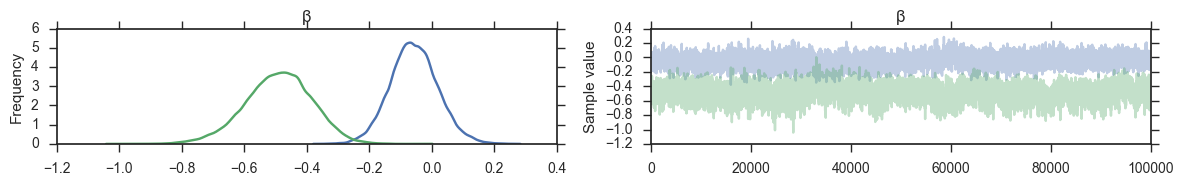

In [55]:
traceplot(weibull_trace[n_burn:], varnames=['β']);

Weibull shape parameter

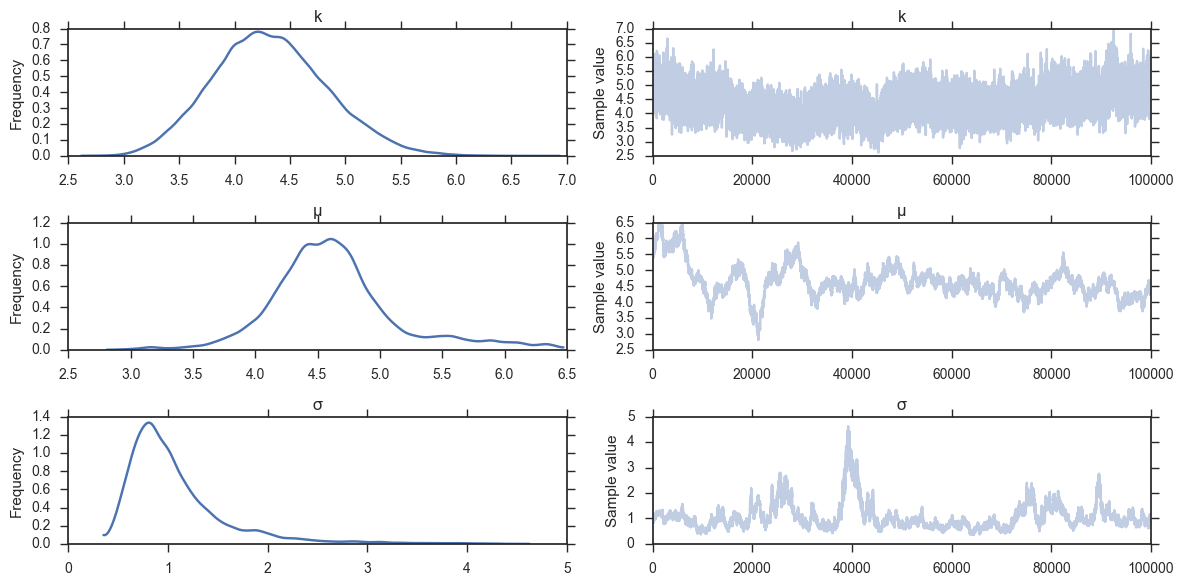

In [56]:
traceplot(weibull_trace[n_burn:], varnames=['k', 'μ', 'σ']);

In [57]:
baseline_lam = np.exp(weibull_trace['μ'][n_burn:])
non_power_lam = np.exp(weibull_trace['μ'][n_burn:] + weibull_trace['β'][n_burn:, 0])
power_lam = np.exp(weibull_trace['μ'][n_burn:] + weibull_trace['β'][n_burn:, 0] + weibull_trace['β'][n_burn:, 1])
k_trace = weibull_trace['k'][n_burn:]

In [58]:
n_intervals = 120
interval_bounds = np.arange(0, n_intervals + 1, 1)

In [59]:
def cum_weibull_hazard(lam, k=k_trace, t=n_intervals):
    return (k.reshape(-1,1)*(1/lam.reshape(-1,1))**k.reshape(-1,1) * np.arange(t)**(k.reshape(-1,1) - 1)).cumsum(axis=-1)

def weibull_survival(lam, k=k_trace, t=n_intervals):
    return np.exp(-cum_weibull_hazard(lam, k, t))

In [60]:
def plot_with_hpd(x, lam, f, ax, color=None, label=None, alpha=0.05, debug=False, **kwargs):

    m = f(lam, **kwargs).mean(axis=0)
    
    percentiles = 100 * np.array([alpha / 2., 1. - alpha / 2.])
    hpd = np.percentile(f(lam, **kwargs), percentiles, axis=0)
    
    if debug:
        import pdb;pdb.set_trace()
    ax.fill_between(x, hpd[0], hpd[1], color=color, alpha=0.25)
    ax.step(x, m, color=color, label=label);

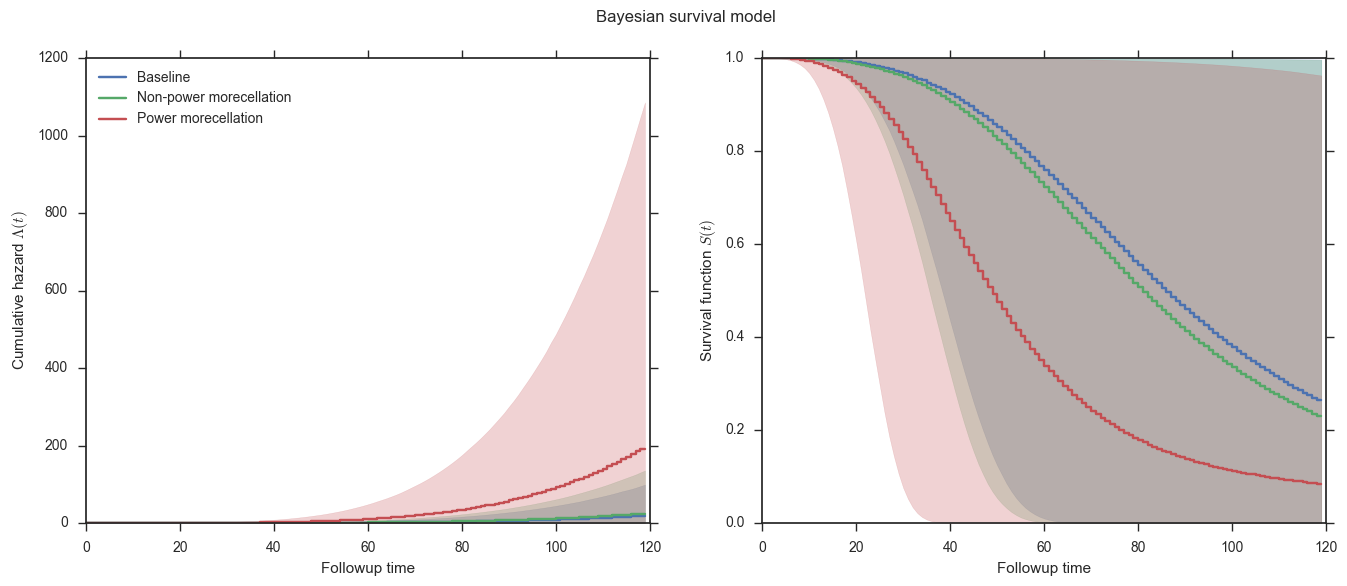

In [61]:
fig, (hazard_ax, surv_ax) = plt.subplots(ncols=2, sharex=True, sharey=False, figsize=(16, 6))

plot_with_hpd(interval_bounds[:-1], baseline_lam, cum_weibull_hazard,
              hazard_ax, color=blue, label='Baseline')
plot_with_hpd(interval_bounds[:-1], non_power_lam, cum_weibull_hazard,
              hazard_ax, color=green, label='Non-power morecellation')
plot_with_hpd(interval_bounds[:-1], power_lam, cum_weibull_hazard,
              hazard_ax, color=red, label='Power morecellation')

hazard_ax.set_xlim(0, n_intervals);
hazard_ax.set_xlabel('Followup time');

hazard_ax.set_ylabel(r'Cumulative hazard $\Lambda(t)$');

hazard_ax.legend(loc=2);

plot_with_hpd(interval_bounds[:-1], baseline_lam, weibull_survival,
              surv_ax, color=blue)
plot_with_hpd(interval_bounds[:-1], non_power_lam, weibull_survival,
              surv_ax, color=green)
plot_with_hpd(interval_bounds[:-1], power_lam, weibull_survival,
              surv_ax, color=red)

surv_ax.set_xlim(0, n_intervals);
surv_ax.set_xlabel('Followup time');

surv_ax.set_ylabel('Survival function $S(t)$');

fig.suptitle('Bayesian survival model');

The above is a much more reasonable fit.

### Summary statistics

Time (months) at which mean survival is 0.5 for each subgroup:

In [62]:
baseline_survival = weibull_survival(baseline_lam)
non_power_survival = weibull_survival(non_power_lam)
power_survival = weibull_survival(power_lam)

In [63]:
np.where(baseline_survival.mean(axis=0)<=0.5)[0][0]

87

In [64]:
np.where(non_power_survival.mean(axis=0)<=0.5)[0][0]

82

In [65]:
np.where(power_survival.mean(axis=0)<=0.5)[0][0]

50

Proportion alive after 5 years

In [66]:
baseline_survival_5 = baseline_survival[:, 60]
non_power_survival_5 = non_power_survival[:, 60]
power_survival_5 = power_survival[:, 60]

In [67]:
print('Baseline 5-year median survival: {0} {1}'.format(np.median(baseline_survival), 
                                                        np.percentile(baseline_survival, [2.5, 97.5])))

Baseline 5-year median survival: 0.9206089049428128 [  1.57789228e-08   9.99999924e-01]


In [68]:
print('Non-power morcellation median 5-year survival: {0} {1}'.format(np.median(non_power_survival_5), 
                                                        np.percentile(non_power_survival_5, [2.5, 97.5])))

Non-power morcellation median 5-year survival: 0.8391497943720322 [ 0.00159116  0.99984489]


In [69]:
print('Power morcellation median 5-year survival: {0} {1}'.format(np.median(power_survival_5), 
                                                        np.percentile(power_survival_5, [2.5, 97.5])))

Power morcellation median 5-year survival: 0.2425078995538999 [  1.13179590e-21   9.98498115e-01]


Ratio of hazards at 5 years between power and non-power morecellation

In [70]:
def weibull_hazard(lam, t, k=k_trace):
    return (k.reshape(-1,1)*(1/lam.reshape(-1,1))**k.reshape(-1,1) * t**(k.reshape(-1,1) - 1))

In [71]:
non_power_hazard_5 = weibull_hazard(non_power_lam, 60).mean(axis=0)
non_power_hazard_5

array([ 0.08578692])

In [72]:
power_hazard_5 = weibull_hazard(power_lam, 60).mean(axis=0)
power_hazard_5

array([ 0.65964587])

In [73]:
hazard_ratio = weibull_hazard(power_lam, 60)/weibull_hazard(non_power_lam, 60)

In [75]:
print('Hazard ratio (power vs non-power) at 5 years: {0} {1}'.format(hazard_ratio.mean(), 
                                                                     np.percentile(hazard_ratio, [2.5, 97.5])))

Hazard ratio (power vs non-power) at 5 years: 9.297918939005463 [  3.42588164  21.25125626]
